In [1]:
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from itertools import groupby
import os


# for feature selection
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour',
    'time_in_secs', 'num_dayofweek','activity_ratio', 'mean_author_sentiment_sign',
    'mean_author_sentiment_magnitude',
    ]
params = {
    'regression_infile': "regression_thread_data.p",
    'thread_infile': 'clean_5_thread_data.p',
    'FSS_pickle_outfile': "weekly_FSS_metrics.p",
    'collection window': 7,
    'model window': 7,
    'step': 7,
    'performance scoring method': 'roc_auc',
    'x cols': X_COLS,
    'y col': 'success'
}

outdir = 'feature_selection_0'
regression_params_outfile = 'regression_params.xlsx'
regression_metrics_outfile = 'regression_metrics.xlsx'
pickle_outfile = 'regression_data.p'

In [3]:
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [4]:
params_df = pd.DataFrame.from_dict(params, orient='index').rename(columns={0: 'input'})
params_df.index.name = 'param'
params_df

,input
param,
regression_infile,regression_thread_data.p
thread_infile,clean_5_thread_data.p
FSS_pickle_outfile,weekly_FSS_metrics.p
collection window,7
model window,7
step,7
performance scoring method,roc_auc
x cols,"[sentiment_sign, sentiment_magnitude, author_a..."
y col,success


In [6]:
def get_date(timestamp):
    return timestamp.date()

def get_score(row):
    if row.thread_id == row.id:
        return row.subject_sentiment_score
    else:
        return row.body_sentiment_score
    
def float_seconds(time_row):
    hours = time_row.hour
    minutes = time_row.minute
    seconds = time_row.second
    return hours*60*60 + minutes*60 + seconds

def get_dayofweek(timestamp):
    return timestamp.dayofweek

def get_hour(timestamp):
    return timestamp.hour

column_functions = {
    'time_in_secs': float_seconds,
    'num_dayofweek': get_dayofweek,
    'hour': get_hour
}

In [7]:
def get_thread_collection_data(thread_data, date_array, date_index, collection_window=params['collection window']):

    # get collection dates
    collection_dates = date_array[date_index:date_index+collection_window]

    # get thread data in collection dates
    thread_collection_data = thread_data[thread_data.timestamp.apply(get_date).isin(collection_dates)]

    # separate by activity
    thread_activity = {
        'all_activity': thread_collection_data,
        'post': thread_collection_data[thread_collection_data.thread_id == thread_collection_data.id],
        'comment': thread_collection_data[thread_collection_data.thread_id != thread_collection_data.id]
    }

    return thread_activity


In [32]:
def get_regression_model_data(regression_data,
    date_array, date_index,
    collection_window=params['collection window'],
    model_window=params['model window']):

    model_dates = date_array[
        date_index + collection_window : date_index + collection_window + model_window
        ]
    
    return regression_data[regression_data.timestamp.apply(get_date).isin(model_dates)]

In [33]:

def get_x_feats_to_run(subreddit_FSS_metrics, period):
    period_metrics = subreddit_FSS_metrics[subreddit_FSS_metrics.index == period].reset_index()
    features = {}
    i=1
    for feature_tuple in period_metrics.feature_names:
        features[i] = list(feature_tuple)
        i += 1
    return features

def get_sm_models(x_list_dict, y=params['y col']):
    models = {}
    for feat_num in x_list_dict:
        models[feat_num] = f"{y} ~"
        for i, feat_name in enumerate(x_list_dict[feat_num]):
            if i != 0:
                models[feat_num] += ' +'
            models[feat_num] += f' {feat_name}'
    return models

In [34]:
def get_author_activity_counts_and_sentiment_means(collection_thread_data_dict):
    started = False
    for key in collection_thread_data_dict:
        author_activity_count = collection_thread_data_dict[key][['author', 'id']].groupby('author').count().rename(columns={'id': f'author_{key}_count'})
        if not started:
            author_activity = author_activity_count
            started = True
        else:
            author_activity = pd.concat((author_activity, author_activity_count), axis=1).fillna(0).astype(int)
        #author_mean_sentiment[key] = collection_thread_data_dict[key][['author', 'sentiment_score']].groupby('author').mean().rename(columns={'sentiment_score': f'author_{key}_mean_sentiment'})

    author_activity['activity_ratio'] = (
        (author_activity.author_comment_count - author_activity.author_post_count)/
        author_activity.author_all_activity_count
    )

    author_mean_sentiment = collection_thread_data_dict['all_activity'][['author', 'sentiment_score']].groupby('author').mean().rename(columns={'sentiment_score': f'mean_author_sentiment'})

    # combine to form author info df
    return pd.concat((author_activity[['author_all_activity_count', 'activity_ratio']], author_mean_sentiment), axis=1)

In [35]:
def get_regression_data_by_time_period(relevant_thread_data, subreddit_regression_data, subreddit_FSS_metrics, date_array, date_index, period_counter):
    # get thread data for collection time period
    # as dict for activity breakdown
    collection_thread_data_by_activity = get_thread_collection_data(relevant_thread_data, date_array, date_index)

    # get activity counts and sentiment means
    author_data = get_author_activity_counts_and_sentiment_means(collection_thread_data_by_activity)
    
    # get regression model data
    regression_model_data = get_regression_model_data(subreddit_regression_data, date_array, date_index)
    
    # combine collected author info data from collection period with model data in model time period
    regression_model_data = regression_model_data.merge(author_data.reset_index(), on='author')

    # separate mean author sentiment into magnitude and sign
    col = 'mean_author_sentiment'
    regression_model_data[f'{col}_sign'] = np.sign(regression_model_data[col])
    regression_model_data[f'{col}_magnitude'] = np.absolute(regression_model_data[col])

    # make other required cols
    for col in [x for x in column_functions if x in X_COLS]:
        regression_model_data[col] = regression_model_data.timestamp.apply(column_functions[col])
    
    # RUN WHATEVER FUNCTION IS NEEDED
    # get X lists for models to run (output from FSS)
    x_mods_to_run = get_x_feats_to_run(subreddit_FSS_metrics, period_counter)

    # make dict of statsmodels format models to run
    sm_model_strings = get_sm_models(x_mods_to_run)

    out_dict = {
        'model_strings': sm_model_strings,
        'data': regression_model_data
        }

    return out_dict

In [51]:
def run_regressions(relevant_thread_data, subreddit_regression_data, subreddit_FSS_metrics, date_array, date_index, period_counter):
    regression_dict = get_regression_data_by_time_period(
        relevant_thread_data, subreddit_regression_data,
        subreddit_FSS_metrics,date_array, date_index, period_counter)
    model_results = {}
    param_dict = {}
    for key in regression_dict['model_strings']:
        print(f"Model {key}")
        logit_mod = smf.logit(regression_dict['model_strings'][key], data=regression_dict['data']).fit()
        model_results[key] = {}
        model_results[key]['num_features'] = key
        model_results[key]['model'] = regression_dict['model_strings'][key]
        model_results[key]['aic'] = logit_mod.aic
        model_results[key]['bic'] = logit_mod.bic
    
        param_dict[key] = pd.DataFrame(logit_mod.params).rename(columns={0: key})
        
        model_results[key]['auc'] = metrics.roc_auc_score(regression_dict['data'].success, logit_mod.predict())
        
    
    model_results = pd.DataFrame.from_dict(model_results, orient='index')

    out_dict = {
        'regression_params': param_dict,
        'metrics': model_results
    }

    return out_dict

In [52]:
def get_AIC_BIC_by_time_period(subreddit_thread_data,
                                subreddit_regression_data,
                                subreddit_FSS_metrics,
                                collection_window=params['collection window'],
                                model_window=params['model window'],
                                step=params['step']
                                ):

    # get one col for sentiment score
    subreddit_thread_data['sentiment_score'] = subreddit_thread_data.apply(get_score, axis = 1)

    # only use wanted cols
    relevant_thread_data = subreddit_thread_data[['thread_id', 'id', 'timestamp', 'author', 'sentiment_score']]
    
    # get array of dates in dataset
    date_array = relevant_thread_data.timestamp.apply(get_date).unique()

    # start time period counter (start on 1 as period 0 is collection data not modelled)
    period_counter = 1

    # get dict for info collection
    regression_metrics = {}

    # iterate through date array windows
    for date_index in range(0, len(date_array) - (collection_window + model_window), step):
        print(f"Period {period_counter}")

        regression_metrics[period_counter] = run_regressions(
            relevant_thread_data, subreddit_regression_data, subreddit_FSS_metrics, date_array, date_index, period_counter
            )
        
        # add another week to counter
        period_counter += 1
    
    return regression_metrics

        


In [28]:
regression_df = pickle.load(open(params['regression_infile'], 'rb'))
thread_df = pickle.load(open(params['thread_infile'], 'rb'))
FSS_metrics = pickle.load(open(params['FSS_pickle_outfile'], 'rb'))



In [54]:
regression_metrics = {}
for subreddit in FSS_metrics:
    print(f"{subreddit}")
    regression_metrics[subreddit] = get_AIC_BIC_by_time_period(
        thread_df[subreddit],
        regression_df[subreddit],
        FSS_metrics[subreddit])

books
Period 1
0
7
Model 1
Optimization terminated successfully.
         Current function value: 0.575659
         Iterations 5
Model 2
Optimization terminated successfully.
         Current function value: 0.549174
         Iterations 6
Model 3
Optimization terminated successfully.
         Current function value: 0.536318
         Iterations 6
Model 4
Optimization terminated successfully.
         Current function value: 0.535992
         Iterations 6
Model 5
Optimization terminated successfully.
         Current function value: 0.535981
         Iterations 6
Model 6
Optimization terminated successfully.
         Current function value: 0.535096
         Iterations 6
Model 7
Optimization terminated successfully.
         Current function value: 0.532314
         Iterations 6
Model 8
Optimization terminated successfully.
         Current function value: 0.532103
         Iterations 6
Model 9
Optimization terminated successfully.
         Current function value: 0.530634
         Iter

In [54]:
for subreddit in regression_metrics:
    print(subreddit)
    metrics_dict = {}
    for period in regression_metrics[subreddit]:
        # output regression params
        regression_params_outfile_path = f"{outdir}/{subreddit}_p{period}_{regression_params_outfile}"
        print(regression_params_outfile_path)
        with pd.ExcelWriter(regression_params_outfile_path, engine='xlsxwriter') as writer:
            params_df.to_excel(writer, sheet_name='inputs')
            regression_metrics[subreddit][period]['metrics'][['num_features', 'model']].to_excel(writer, sheet_name='models', index=False)
            for mod_nb in regression_metrics[subreddit][period]['regression_params']:
                regression_metrics[subreddit][period]['regression_params'][mod_nb].to_excel(writer, sheet_name=f"mod_{mod_nb}", index=False)
        

  # output regression metrics
regression_metrics_outfile_path = f"{outdir}/{regression_metrics_outfile}"

with pd.ExcelWriter(regression_metrics_outfile_path, engine='xlsxwriter') as writer:
    params_df.to_excel(writer, sheet_name='inputs')
    subreddit_metrics_dict = {}
    for subreddit in regression_metrics:
        started = False
        for period in regression_metrics[subreddit]:
            metrics_df = regression_metrics[subreddit][period]['metrics'].copy()
            metrics_df = metrics_df.set_index('num_features')
            metrics_df.columns = pd.MultiIndex.from_arrays([[period]*len(metrics_df.columns), metrics_df.columns])
            metrics_df.columns.set_names(['period','metrics'], inplace=True)
            if not started:
                subreddit_metrics = metrics_df
                started = True
            else:
                subreddit_metrics = pd.concat((subreddit_metrics, metrics_df), axis=1)
        subreddit_metrics_dict[subreddit] = subreddit_metrics

        min_subset = [i for i in subreddit_metrics.columns if ((i[1] =='aic')|(i[1] =='bic'))]
        max_subset = [i for i in subreddit_metrics.columns if i[1] =='auc']
        
        metrics_styler = (
            subreddit_metrics.style
            .highlight_min(subset=min_subset, color='green', axis=0)
            .highlight_max(subset=max_subset, color='green', axis=0)
        )
        metrics_styler.to_excel(writer, sheet_name=subreddit)

  

books
feature_selection_0/books_p1_regression_params.xlsx
feature_selection_0/books_p2_regression_params.xlsx
feature_selection_0/books_p3_regression_params.xlsx
conspiracy
feature_selection_0/conspiracy_p1_regression_params.xlsx
feature_selection_0/conspiracy_p2_regression_params.xlsx
feature_selection_0/conspiracy_p3_regression_params.xlsx
crypto
feature_selection_0/crypto_p1_regression_params.xlsx
feature_selection_0/crypto_p2_regression_params.xlsx
feature_selection_0/crypto_p3_regression_params.xlsx
politics
feature_selection_0/politics_p1_regression_params.xlsx
feature_selection_0/politics_p2_regression_params.xlsx
feature_selection_0/politics_p3_regression_params.xlsx
feature_selection_0/politics_p4_regression_params.xlsx
feature_selection_0/politics_p5_regression_params.xlsx
feature_selection_0/politics_p6_regression_params.xlsx


In [82]:
pickle.dump(regression_metrics, open(f"{outdir}/{pickle_outfile}", 'wb'))

In [5]:
regression_metrics = pickle.load(open(f"{outdir}/{pickle_outfile}", 'rb'))

In [38]:
pickle.dump(subreddit_metrics_dict, open(f"{outdir}/metrics_dict_{pickle_outfile}", 'wb'))

In [5]:
subreddit_metrics_dict = pickle.load(open(f"{outdir}/metrics_dict_{pickle_outfile}", 'rb'))

In [19]:
subreddit_metrics_dict['books'].index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='num_features')

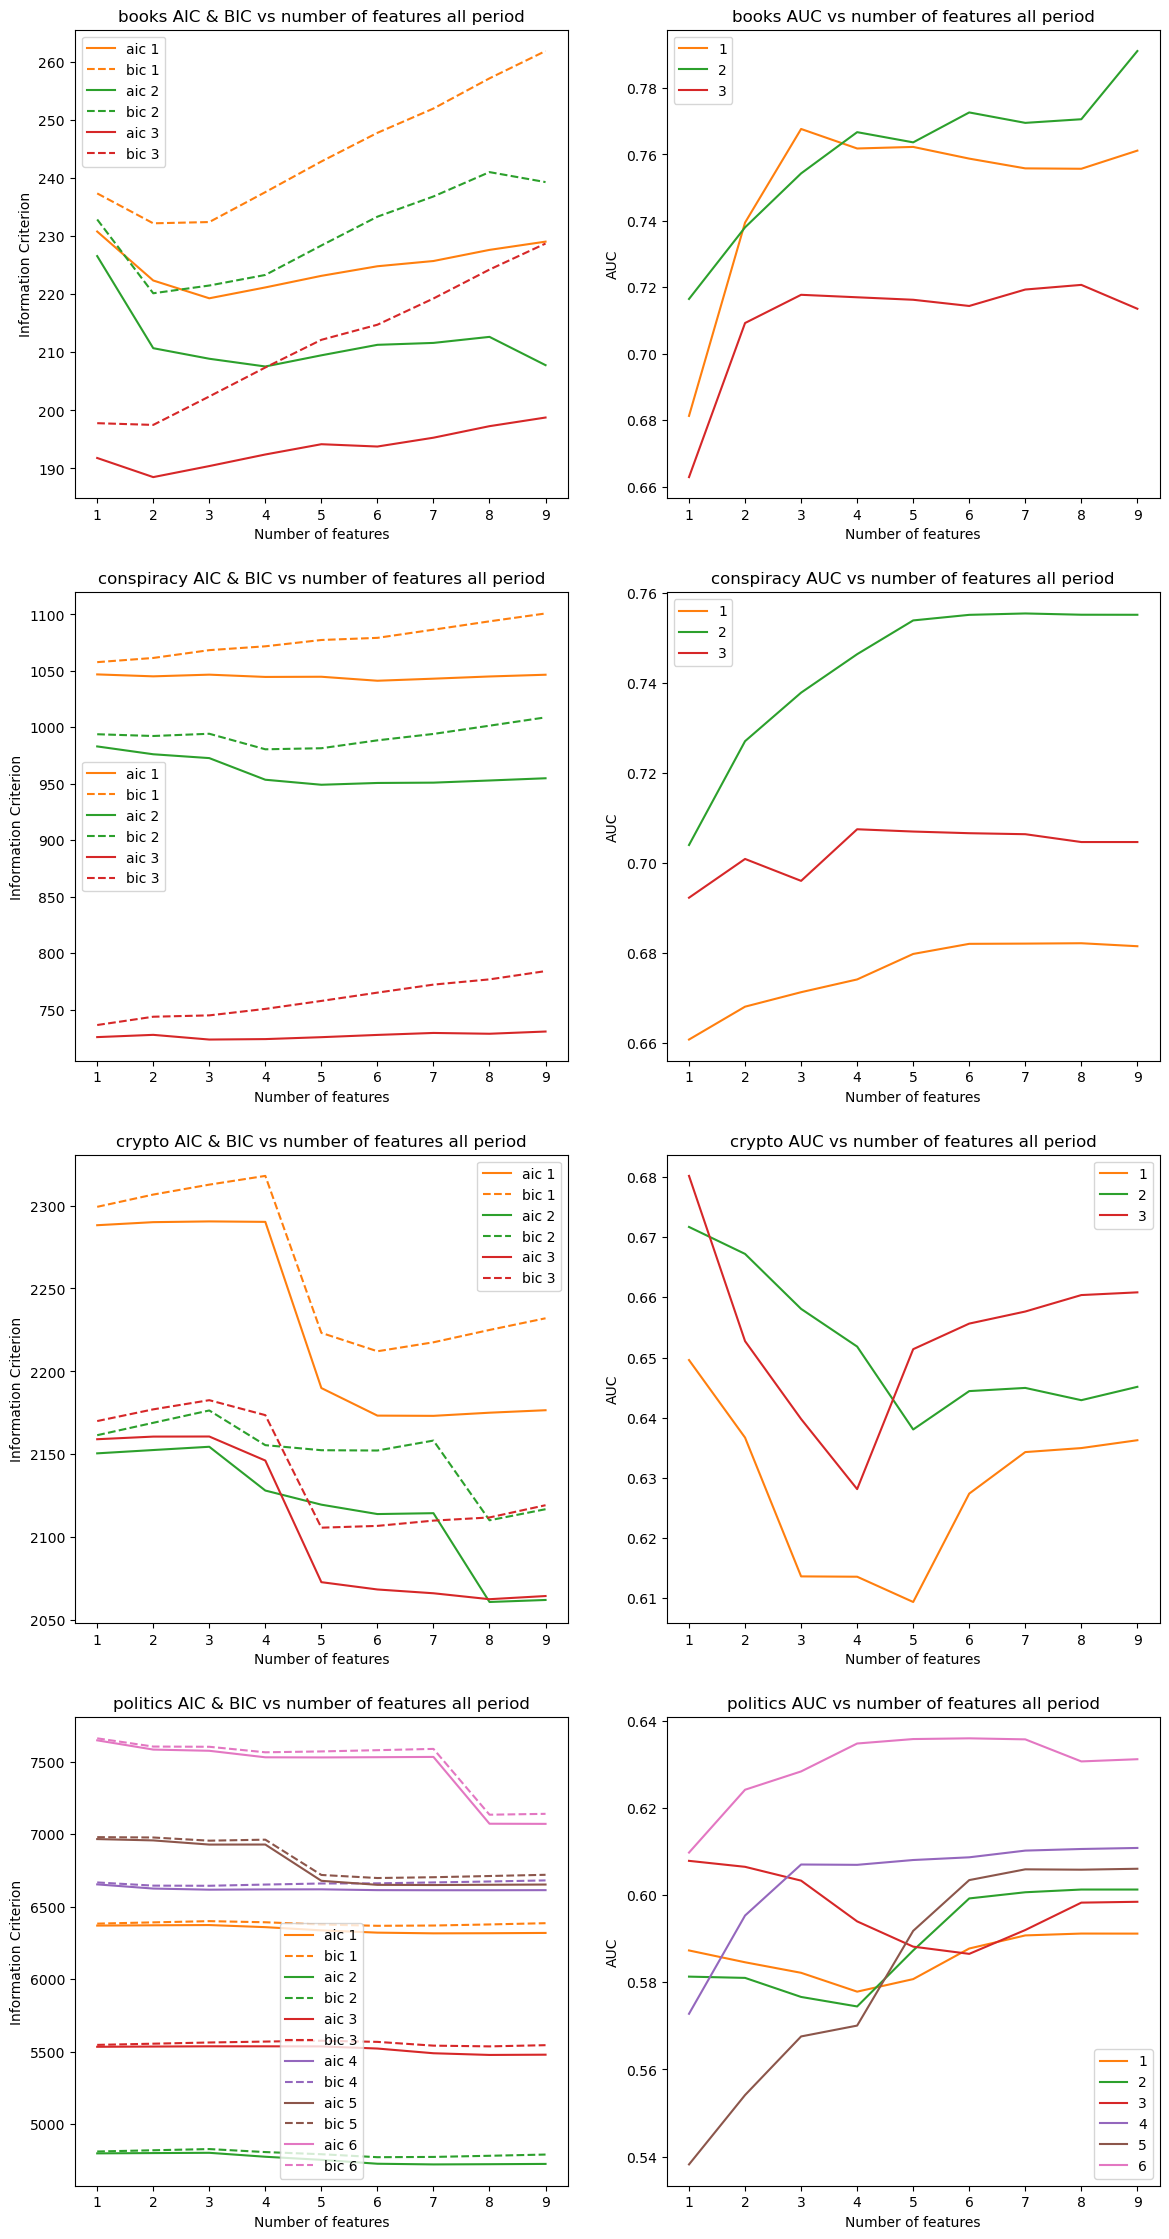

In [29]:
fig, axes = plt.subplots(len(subreddit_metrics_dict), 2, figsize=(14, 7*len(subreddit_metrics_dict)))
i = 0
col_linestyle = {
    'aic': 'solid',
    'bic': 'dashed'
}
col_list = list(mcolors.TABLEAU_COLORS.keys())
for subreddit in subreddit_metrics_dict:
    for period in subreddit_metrics_dict[subreddit].columns.levels[0]:
        for criterion in col_linestyle:
            axes[i, 0].plot(
                subreddit_metrics_dict[subreddit].index,
                subreddit_metrics_dict[subreddit].loc[:, (period, criterion)],
                color=col_list[period], linestyle=col_linestyle[criterion],
                label=f'{criterion} {period}')
        axes[i, 1].plot(
            subreddit_metrics_dict[subreddit].index,
            subreddit_metrics_dict[subreddit].loc[:, (period, 'auc')],
            color=col_list[period],
            label=f'{period}'
        )
    axes[i, 0].set_title(f'{subreddit} AIC & BIC vs number of features all period')
    axes[i, 0].set_ylabel(f'Information Criterion')
    axes[i, 0].set_xlabel('Number of features')
    axes[i, 0].legend()

    
    axes[i, 1].set_title(f'{subreddit} AUC vs number of features all period')
    axes[i, 1].set_ylabel(f'AUC')
    axes[i, 1].set_xlabel('Number of features')
    axes[i, 1].legend()
    
    i += 1

plt.show()


